## Preamble



In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["text.usetex"] = True
import pandas as pd
import numpy as np
from getdist import plots, MCSamples
from IPython.display import HTML, display
import tabulate
import glob

## Plot cosmological parameters distribution



### Cosmo. parameters LaTeX labels



In [1]:
labels = [r"$\theta_\mathrm{MC}$",
          r"$A_\mathrm{s}$",
          r"$n_\mathrm{s}$",
          r"$\Omega_\mathrm{b}h^2$",
          r"$\Omega_\mathrm{c}h^2$",
          r"$\chi^2-\chi^2_\mathrm{min}$"]

### Get cosmo. parameters from output file



In [1]:
def get_params(path, pattern="*.likelihood", weight=False):
    import os, glob
    all_files = glob.glob(os.path.join(path, pattern))
    # Sort alphabetically
    all_files.sort()

    header = pd.read_csv(all_files[0], delim_whitespace=True).columns[1:]
    df = pd.concat((pd.read_table(f, delim_whitespace=True) for f in all_files))

    # Remove '#' in header
    df.drop(df.columns[[-1,]], axis=1, inplace=True)
    df.columns = header
    # Compute delta chi2
    delta_chi2 = df.chi2-np.min(df.chi2)
    # Remove useless columns
    df.drop(columns=["weight", "minuslogpost", "minuslogprior", "minuslogprior__0", "chi2", "chi2__chi2"], inplace=True)
    # Insert Delta chi2 before As (which is derived and never plot)
    df.insert(value=delta_chi2, column="delta_chi2", loc=len(df.columns))

    params = np.array(df)
    return params

### Show input values of cosmo. parameters



In [1]:
def show_ref(g):
    ref = [1.04164/100, np.exp(3.058)/1e10, 0.9649, 0.02212, 0.1210]
    for i, r in enumerate(ref):
        kwargs = dict(color="gray", ls="--", lw=1)
        for ax in g.subplots[:,i]:
            if ax: ax.axvline(r, **kwargs)
        for ax in g.subplots[i,:i]:
            if ax: ax.axhline(r, **kwargs)

### Results from pure Planck simulation



#### Cosmo. parameters distribution



In [1]:
params = get_params(r"/home/garrido/Workdir/CMB/analysis/beyondCV/output/unbinned")
samples = MCSamples(samples=params, names=labels)

# Out[1100]:

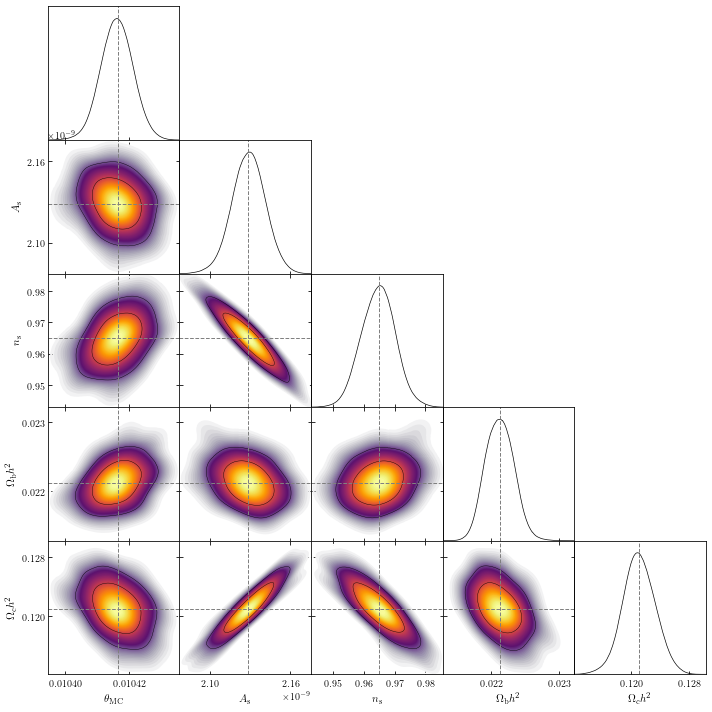

In [1]:
g = plots.getSubplotPlotter()
g.settings.colormap = "inferno"
g.triangle_plot(samples, params=labels[:-1], shaded=True)
show_ref(g)

# Out[1101]:

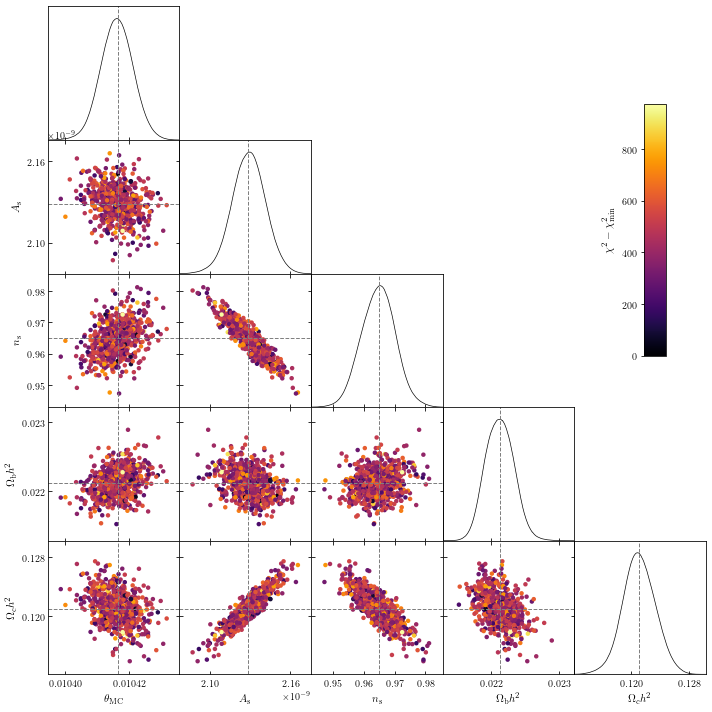

In [1]:
g = plots.getSubplotPlotter()
g.settings.colormap_scatter = "inferno"
g.triangle_plot(samples, params=labels[:-1],
                plot_3d_with_param="$\chi^2-\chi^2_\mathrm{min}$", scatter_size=20)
show_ref(g)

In [1]:
print("Number of sucessful minimization :", np.alen(params))

Number of sucessful minimization : 638

In [1]:
min_mean = np.mean(params, axis=0)
min_std  = np.std(params, axis=0)
fisher = np.array([5.1265507267143515e-06, 1.2854648947626772e-11, 0.005589724100405197, 0.00020382255228959767, 0.002334040314343261, 1.])
lines = [[r"$\mu$"], [r"$\sigma$"], [r"$\sigma$ (Fisher)"], [r"$\Delta\sigma$ (min-Fisher) [%]"]]
table = np.stack([min_mean, min_std, fisher, 100*(min_std-fisher)/fisher])
table = np.append(lines, table, axis=1)

In [1]:
display(HTML(tabulate.tabulate(table, headers=labels, tablefmt="html")))

# Out[17]:
<IPython.core.display.HTML object>

## Simons Observatory ⊗ Planck



### \ell \in [2; 3000]



In [1]:
params_SO   = get_params(r"/home/garrido/Workdir/CMB/analysis/beyondCV/output/ell_2_3000", "*SO.likelihood")
params_SOxP = get_params(r"/home/garrido/Workdir/CMB/analysis/beyondCV/output/ell_2_3000", "*SOxP.likelihood")
params_P    = get_params(r"/home/garrido/Workdir/CMB/analysis/beyondCV/output/ell_2_3000", "*_P.likelihood")
params_SO.shape, params_SOxP.shape, params_P.shape

# Out[1085]:
((978, 6), (978, 6), (978, 6))

#### Triangle plot



In [1]:
samples_SO   = MCSamples(samples=params_SO, names=labels, label="SOxSO")
samples_SOxP = MCSamples(samples=params_SOxP, names=labels, label="SOxP")
samples_P    = MCSamples(samples=params_P, names=labels, label="PxP")

# Out[1092]:

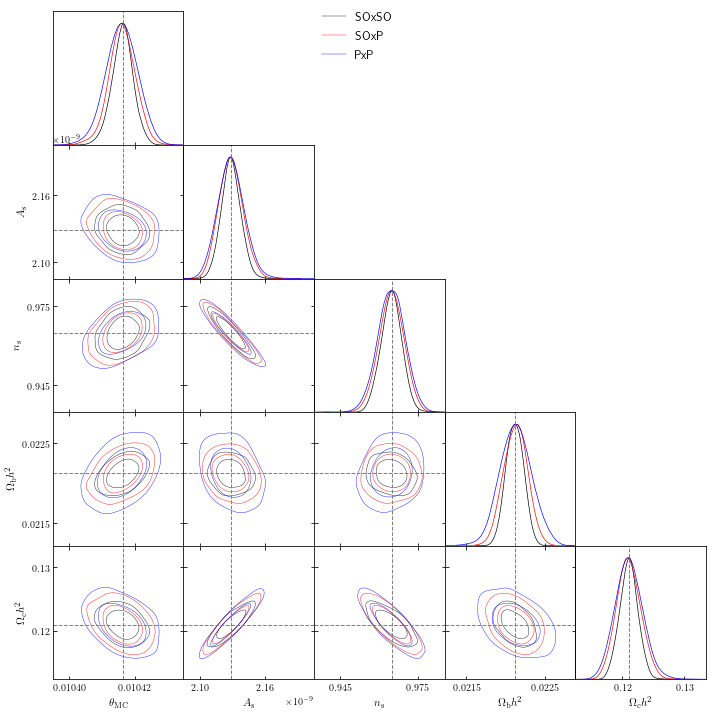

In [1]:
g = plots.getSubplotPlotter()
g.triangle_plot([samples_SO, samples_SOxP, samples_P], params=labels[:-1])
show_ref(g)

#### Variances of parameters



In [1]:
lines = [[r"$\mu$(SOxSO)"], [r"$\mu$(SOxP)"], [r"$\mu$(PxP)"],
         [r"$\sigma$(SOxSO)"], [r"$\sigma$(SOxP)"], [r"$\sigma$(PxP)"],
         [r"$\sigma$(SOxSO - PxP)"], [r"$\sigma$(SOxSO - SOxP)"], [r"$\sigma$(SOxSO + PxP - 2 SOxP)"]]
std_SO, std_SOxP, std_P = np.std(params_SO, axis=0), np.std(params_SOxP, axis=0), np.std(params_P, axis=0)
std_SOmP = np.std(params_SO-params_P, axis=0)
std_SOmSOxP = np.std(params_SO-params_SOxP, axis=0)
std_SOpPm2SOxP = np.std(params_SO + params_P - 2*params_SOxP, axis=0)
table = np.stack([np.mean(params_SO, axis=0),
                  np.mean(params_SOxP, axis=0),
                  np.mean(params_P, axis=0),
                  std_SO, std_SOxP, std_P,
                  std_SOmP, std_SOmSOxP, std_SOpPm2SOxP
])
table = np.append(lines, table, axis=1)
display(HTML(tabulate.tabulate(table, headers=labels, tablefmt="html")))

Set PxP deviation as standard for further comparison



In [1]:
ref_std = std_P
print(ref_std)

# Out[1098]:

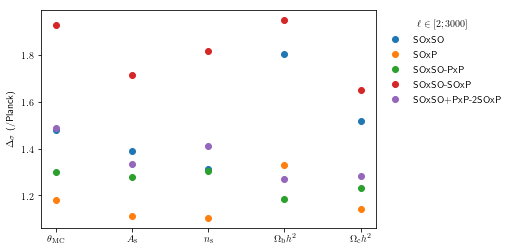

In [1]:
x = np.arange(5)
plt.plot(x, (ref_std/std_SO)[:-1], "o", label="SOxSO")
plt.plot(x, (ref_std/std_SOxP)[:-1], "o", label="SOxP")
plt.plot(x, (ref_std/std_SOmP)[:-1], "o", label="SOxSO-PxP")
plt.plot(x, (ref_std/std_SOmSOxP)[:-1], "o", label="SOxSO-SOxP")
plt.plot(x, (ref_std/std_SOpPm2SOxP)[:-1], "o", label="SOxSO+PxP-2SOxP")
plt.xticks(x, labels[:-1])
plt.ylabel(r"$\Delta_\sigma$ (/Planck)")
plt.legend(loc="upper left", title=r"$\ell\in[2; 3000]$", bbox_to_anchor=(1,1))

### \ell \in [50; 2000]



In [1]:
params_SO   = get_params(r"/home/garrido/Workdir/CMB/analysis/beyondCV/output/ell_50_2000", "*SO.likelihood")
params_SOxP = get_params(r"/home/garrido/Workdir/CMB/analysis/beyondCV/output/ell_50_2000", "*SOxP.likelihood")
params_P    = get_params(r"/home/garrido/Workdir/CMB/analysis/beyondCV/output/ell_50_2000", "*_P.likelihood")
params_SO.shape, params_SOxP.shape, params_P.shape

# Out[877]:
((971, 6), (971, 6), (971, 6))

#### Triangle plot



In [1]:
samples_SO   = MCSamples(samples=params_SO, names=labels, label="SOxSO")
samples_SOxP = MCSamples(samples=params_SOxP, names=labels, label="SOxP")
samples_P    = MCSamples(samples=params_P, names=labels, label="PxP")

# Out[881]:

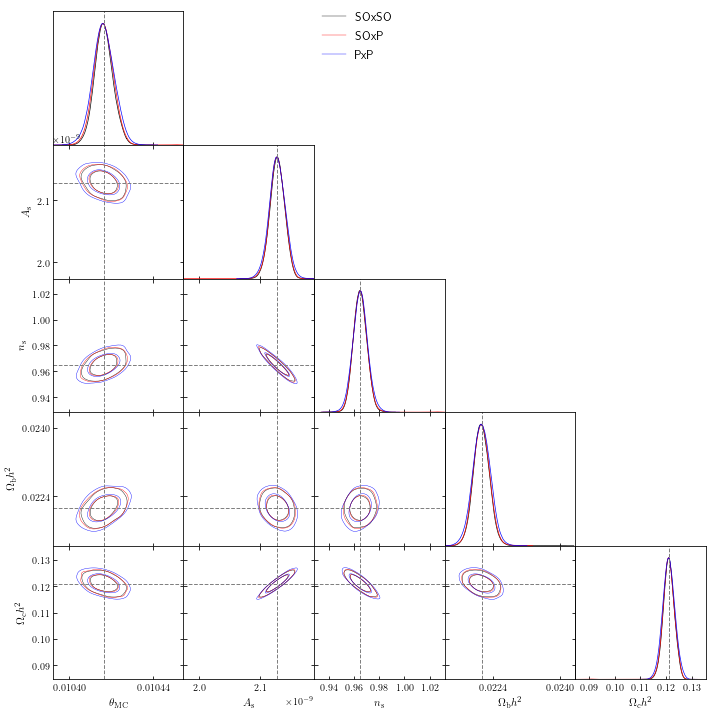

In [1]:
g = plots.getSubplotPlotter()
g.triangle_plot([samples_SO, samples_SOxP, samples_P], params=labels[:-1])
show_ref(g)

#### Variances of parameters



In [1]:
lines = [[r"$\mu$(SOxSO)"], [r"$\mu$(SOxP)"], [r"$\mu$(PxP)"],
         [r"$\sigma$(SOxSO)"], [r"$\sigma$(SOxP)"], [r"$\sigma$(PxP)"],
         [r"$\sigma$(SOxSO - PxP)"], [r"$\sigma$(SOxSO - SOxP)"], [r"$\sigma$(SOxSO + PxP - 2 SOxP)"]]
std_SO, std_SOxP, std_P = np.std(params_SO, axis=0), np.std(params_SOxP, axis=0), np.std(params_P, axis=0)
std_SOmP = np.std(params_SO-params_P, axis=0)
std_SOmSOxP = np.std(params_SO-params_SOxP, axis=0)
std_SOpPm2SOxP = np.std(params_SO + params_P - 2*params_SOxP, axis=0)
table = np.stack([np.mean(params_SO, axis=0),
                  np.mean(params_SOxP, axis=0),
                  np.mean(params_P, axis=0),
                  std_SO, std_SOxP, std_P,
                  std_SOmP, std_SOmSOxP, std_SOpPm2SOxP
])
table = np.append(lines, table, axis=1)
display(HTML(tabulate.tabulate(table, headers=labels, tablefmt="html")))

# Out[885]:

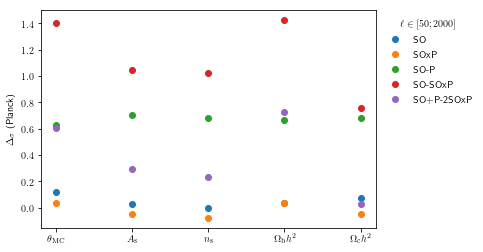

In [1]:
x = np.arange(5)
plt.plot(x, (ref_std/std_SO-1)[:-1], "o", label="SO")
plt.plot(x, (ref_std/std_SOxP-1)[:-1], "o", label="SOxP")
plt.plot(x, (ref_std/std_SOmP-1)[:-1], "o", label="SO-P")
plt.plot(x, (ref_std/std_SOmSOxP-1)[:-1], "o", label="SO-SOxP")
plt.plot(x, (ref_std/std_SOpPm2SOxP-1)[:-1], "o", label="SO+P-2SOxP")
plt.xticks(x, labels[:-1])
plt.ylabel(r"$\Delta_\sigma$ (Planck)")
plt.legend(loc="upper left", title=r"$\ell\in[50; 2000]$", bbox_to_anchor=(1,1))

### \ell \in [50; 1500]



In [1]:
params_SO   = get_params(r"/home/garrido/Workdir/CMB/analysis/beyondCV/output/ell_50_1500", "*SO.likelihood")
params_SOxP = get_params(r"/home/garrido/Workdir/CMB/analysis/beyondCV/output/ell_50_1500", "*SOxP.likelihood")
params_P    = get_params(r"/home/garrido/Workdir/CMB/analysis/beyondCV/output/ell_50_1500", "*_P.likelihood")
params_SO.shape, params_SOxP.shape, params_P.shape

# Out[886]:
((1001, 6), (1001, 6), (1001, 6))

#### Triangle plot



In [1]:
samples_SO   = MCSamples(samples=params_SO, names=labels, label="SOxSO")
samples_SOxP = MCSamples(samples=params_SOxP, names=labels, label="SOxP")
samples_P    = MCSamples(samples=params_P, names=labels, label="PxP")

# Out[888]:

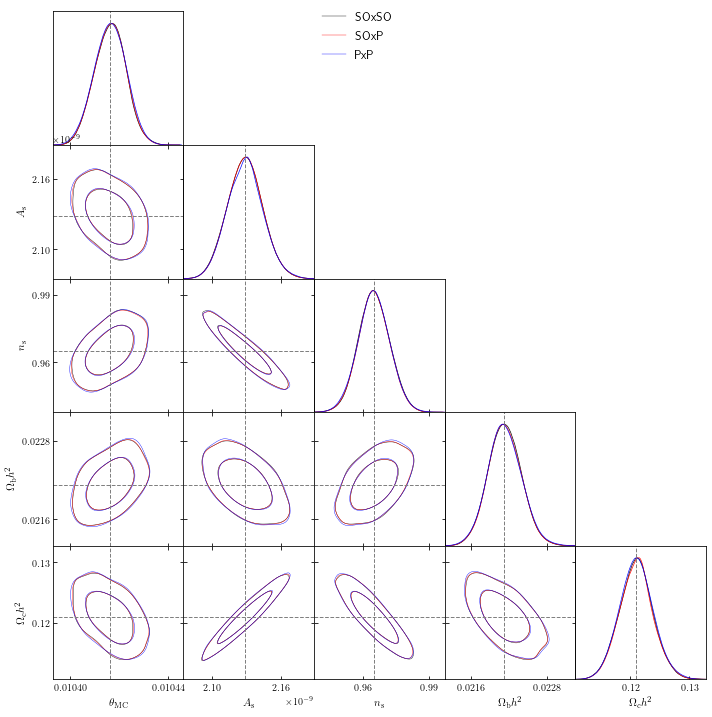

In [1]:
g = plots.getSubplotPlotter()
g.triangle_plot([samples_SO, samples_SOxP, samples_P], params=labels[:-1])
show_ref(g)

#### Variances of parameters



In [1]:
lines = [[r"$\mu$(SOxSO)"], [r"$\mu$(SOxP)"], [r"$\mu$(PxP)"],
         [r"$\sigma$(SOxSO)"], [r"$\sigma$(SOxP)"], [r"$\sigma$(PxP)"],
         [r"$\sigma$(SOxSO - PxP)"], [r"$\sigma$(SOxSO - SOxP)"], [r"$\sigma$(SOxSO + PxP - 2 SOxP)"]]
std_SO, std_SOxP, std_P = np.std(params_SO, axis=0), np.std(params_SOxP, axis=0), np.std(params_P, axis=0)
std_SOmP = np.std(params_SO-params_P, axis=0)
std_SOmSOxP = np.std(params_SO-params_SOxP, axis=0)
std_SOpPm2SOxP = np.std(params_SO + params_P - 2*params_SOxP, axis=0)
table = np.stack([np.mean(params_SO, axis=0),
                  np.mean(params_SOxP, axis=0),
                  np.mean(params_P, axis=0),
                  std_SO, std_SOxP, std_P,
                  std_SOmP, std_SOmSOxP, std_SOpPm2SOxP
])
table = np.append(lines, table, axis=1)
display(HTML(tabulate.tabulate(table, headers=labels, tablefmt="html")))

# Out[890]:

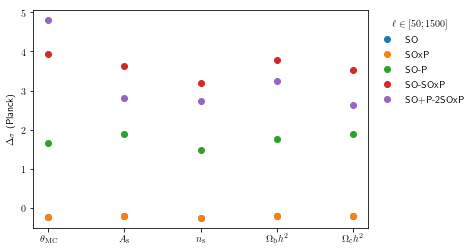

In [1]:
x = np.arange(5)
plt.plot(x, (ref_std/std_SO-1)[:-1], "o", label="SO")
plt.plot(x, (ref_std/std_SOxP-1)[:-1], "o", label="SOxP")
plt.plot(x, (ref_std/std_SOmP-1)[:-1], "o", label="SO-P")
plt.plot(x, (ref_std/std_SOmSOxP-1)[:-1], "o", label="SO-SOxP")
plt.plot(x, (ref_std/std_SOpPm2SOxP-1)[:-1], "o", label="SO+P-2SOxP")
plt.xticks(x, labels[:-1])
plt.ylabel(r"$\Delta_\sigma$ (Planck)")
plt.legend(loc="upper left", title=r"$\ell\in[50; 1500]$", bbox_to_anchor=(1,1))

## MCMC analysis



In [1]:
def get_chains(path):
    import glob
    all_files = glob.glob(path)
    # Sort alphabetically
    all_files.sort()
    chains = {}
    for f in all_files:
        header = pd.read_csv(all_files[0], delim_whitespace=True).columns[1:]
        df = pd.read_table(f, delim_whitespace=True)

        # Remove '#' in header
        df.drop(df.columns[[-1,]], axis=1, inplace=True)
        df.columns = header
        # Compute delta chi2
        delta_chi2 = df.chi2-np.min(df.chi2)

        # Remove useless columns
        df.drop(columns=["minuslogpost", "minuslogprior", "minuslogprior__0", "chi2", "chi2__chi2"], inplace=True)
        # Insert Delta chi2 before As (which is derived and never plot)
        df.insert(value=delta_chi2, column="delta_chi2", loc=len(df.columns)-1)
        key = f.split("/")[-2]
        chains[key] = df
    return chains

ref = [1.04164/100, 3.058, 0.9649, 0.02212, 0.1210, 1]
def plot_chains(path, burnin=0, labels=labels):
    if "$H_0$" in labels:
      ref[0] = 67.5
    chains = get_chains(path=path)
    plt.figure(figsize=(18, 10))
    for i in range(1, len(labels)):
        plt.subplot(2, 4, i)
        plt.ylabel(labels[i-1])
        for k, v in chains.items():
            j = k.split("_")[-1]
            n = np.arange(len(v))
            if 0 < burnin < 1:
                ist = int((1.-burnin)*len(v))
            else:
                ist = int(burnin)
            plt.plot(n[ist:], v.iloc[:,i][ist:], alpha=0.75, color="C{}".format(j))
        if i != len(labels)-1:
            plt.axhline(ref[i-1], color="gray", ls="--", lw=1)
    plt.subplots_adjust(hspace=0.25, wspace=0.3)
    plt.legend([k.replace("_", "\_") for k in chains.keys()], loc="upper left", bbox_to_anchor=(1,1))

### Understanding MCMC /à la/ cobaya



We run several MCMC for PxP survey (&ell; 2; 3000) and **use the covariance matrix from Fisher**
calculation as input of `cobaya` MCMC algorithm. We check how the input covariance matrix changes the
MCMC convergence. Basically, we do the following tests:

-   Covariance matrix/2
-   Covariance matrix
-   Covariance matrix\*2
-   Covariance matrix\*4



In [1]:
labels = [r"$\theta_\mathrm{MC}$",
          r"$\log(10^{10}A_\mathrm{s})$",
          r"$n_\mathrm{s}$",
          r"$\Omega_\mathrm{b}h^2$",
          r"$\Omega_\mathrm{c}h^2$",
          r"$\chi^2-\chi^2_\mathrm{min}$",
          r"$A_\mathrm{s}$"]

result_path=r"/home/garrido/Workdir/CMB/analysis/beyondCV/output/fisher"

#### Covariance matrix divide by 2



# Out[58]:

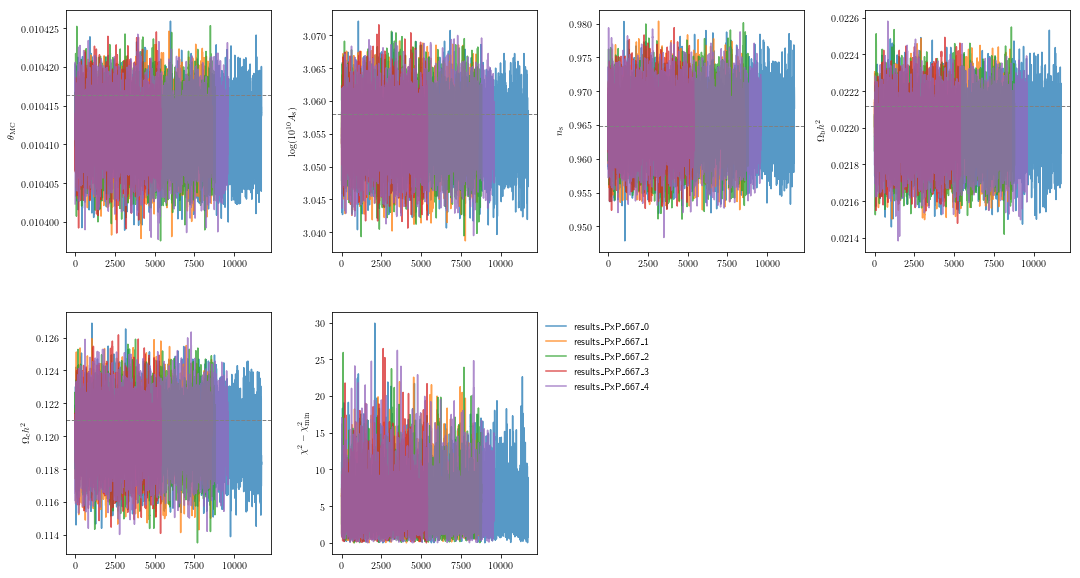

In [1]:
plot_chains(result_path + "/0.5/*_PxP_*/mcmc*.txt", burnin=0)

#### Initial covariance matrix



# Out[57]:

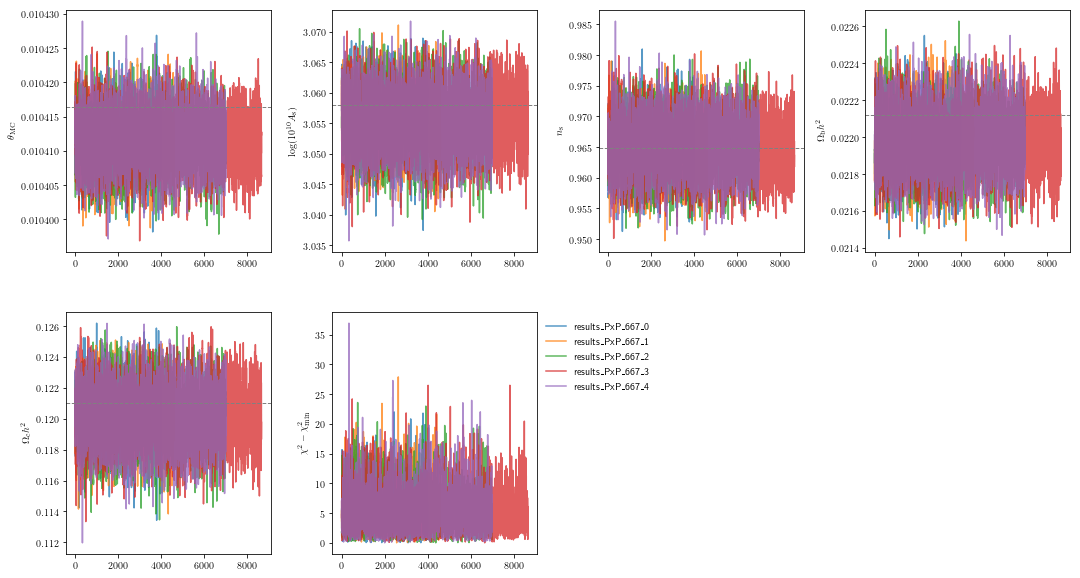

In [1]:
plot_chains(result_path + "/1/*_PxP_*/mcmc*.txt", burnin=0)

#### Covariance matrix multiply by 2



# Out[56]:

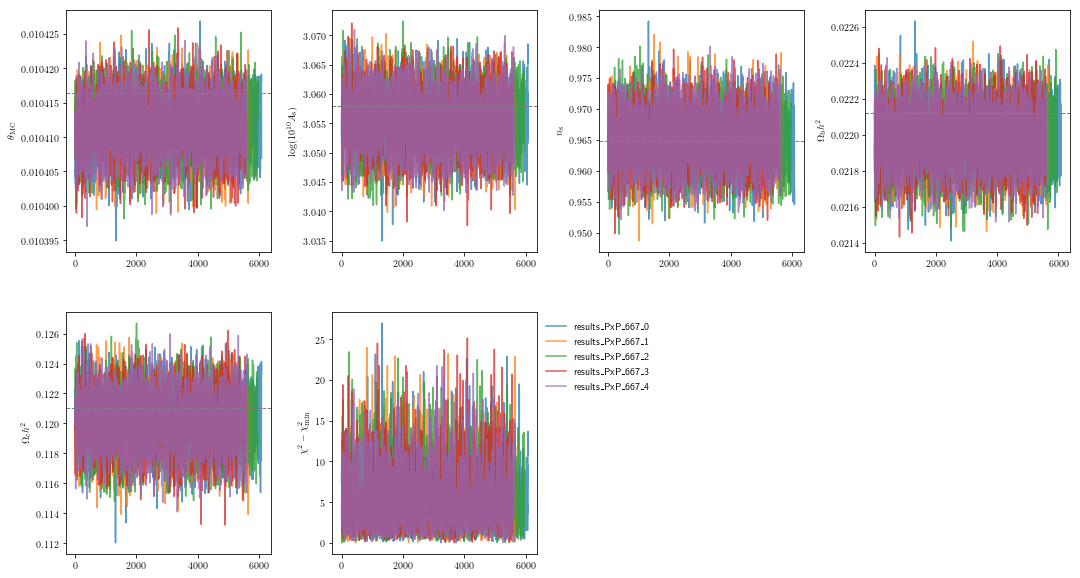

In [1]:
plot_chains(result_path + "/2/*_PxP_*/mcmc*.txt", burnin=0)

#### Covariance matrix multiply by 4



# Out[9]:

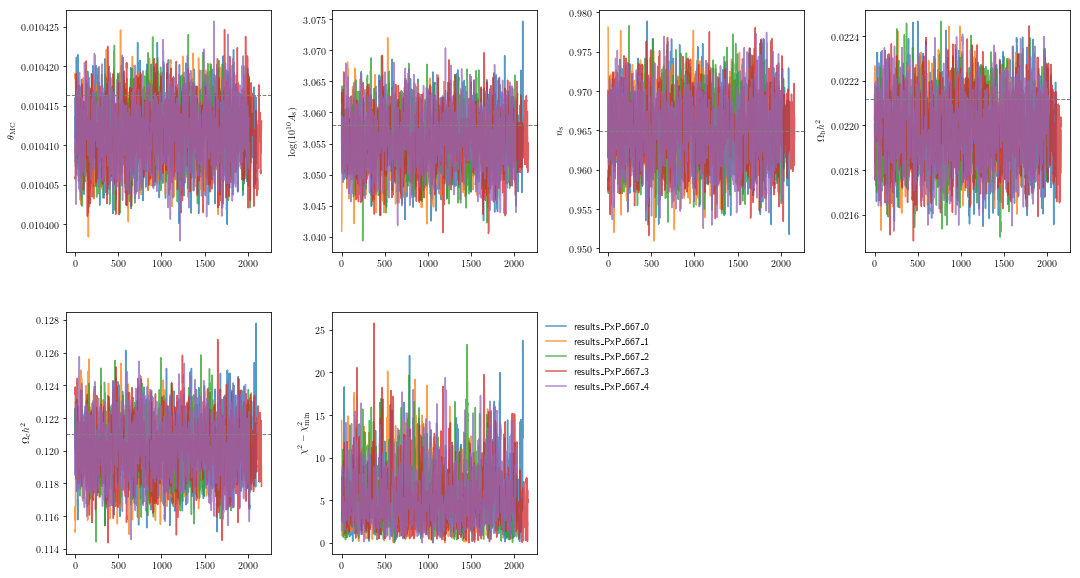

In [1]:
plot_chains(result_path + "/4/*_PxP_*/mcmc*.txt", burnin=0)

#### Remove =proposal_scale=



By default there is a `proposal_scale` parameter for `cobaya` MCMC which is set to 2.4. Here we set it
to 1 and check the results



# Out[55]:

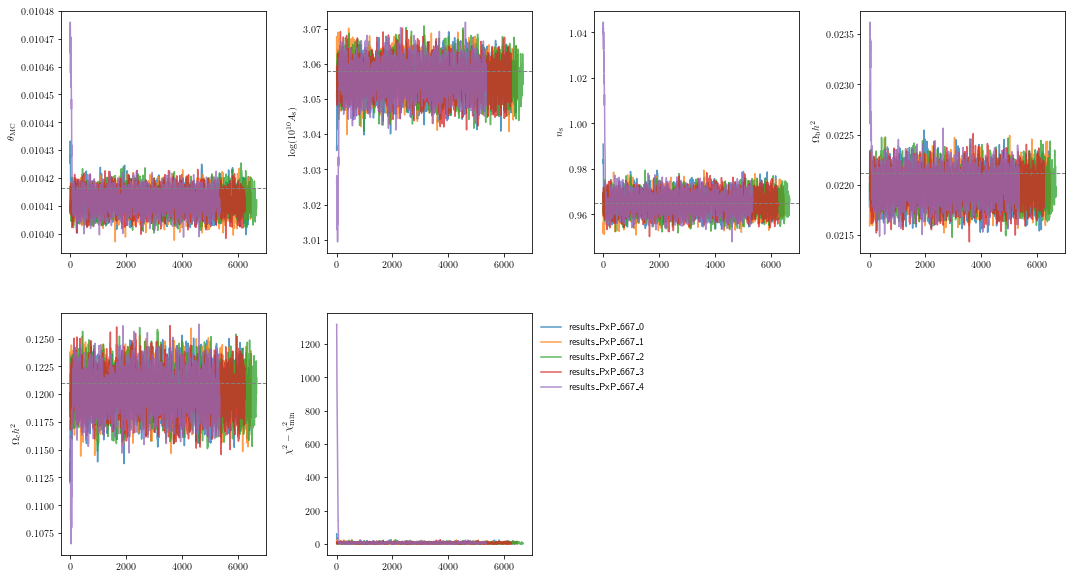

In [1]:
plot_chains(result_path + "/no_proposal_scale/*_PxP_*/mcmc*.txt", burnin=0)

#### Fix Χ²



Fix likelihood definition by adding a 1/2 factor



# Out[71]:

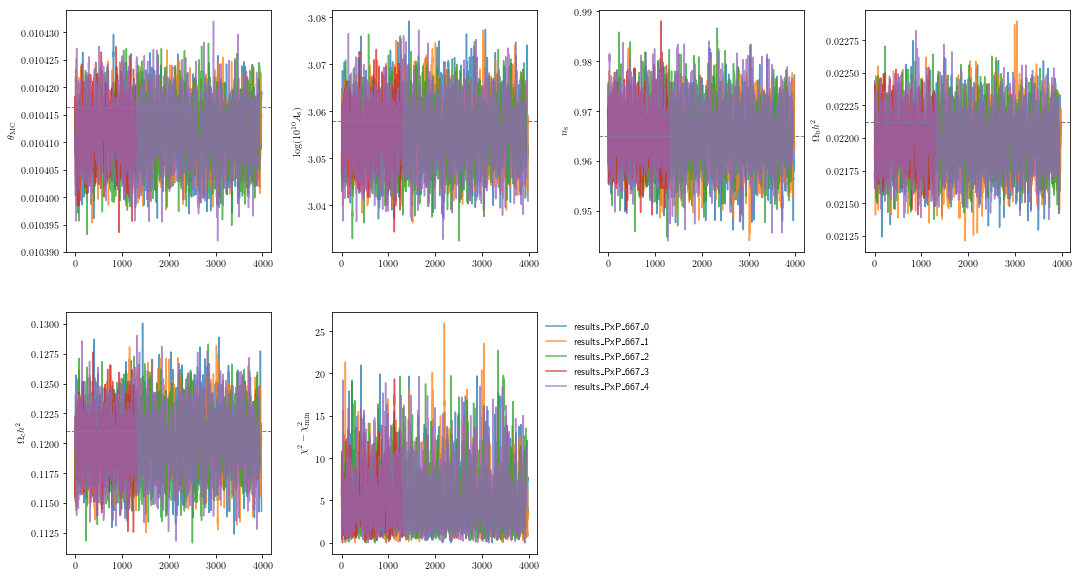

In [1]:
plot_chains(result_path + "/fix_chi2/*_PxP_*/mcmc*.txt", burnin=0)

#### Plotting variances /vs./ Fisher results



# Out[70]:

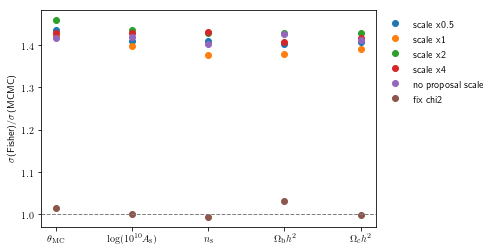

In [1]:
fisher = np.array([5.126550726714351e-06, 0.006039315179940597, 0.005589724100405183, 0.00020382255228959761, 0.002334040314343254])
def get_variance_ratio(scale_factor):
    mcmc = get_mcmc_variances(result_path + "/{}/*_PxP_*/mcmc*.txt".format(scale_factor))
    mcmc = np.mean(np.array(mcmc[:, 1:], dtype=np.float), axis=0)
    return fisher/mcmc

def get_variance_from_covmat(scale_factor):
    all_files = glob.glob(result_path + "/{}/*/mcmc.covmat".format(scale_factor))
    variances = np.zeros((len(all_files), 5))
    for i, f in enumerate(all_files):
        cov = np.loadtxt(f)
        variances[i, :] = np.sqrt(np.diag(cov))
    return fisher/np.mean(variances, axis=1)

x = np.arange(len(labels)-2)
for scale in [0.5, 1, 2, 4]:
  plt.plot(x, get_variance_ratio(scale), "o", label="scale x{}".format(scale))
  # y = get_variance_from_covmat(scale)
  # print(y)
plt.plot(x, get_variance_ratio("no_proposal_scale"), "o", label="no proposal scale".format(scale))
plt.plot(x, get_variance_ratio("fix_chi2"), "o", label="fix chi2".format(scale))
# plt.plot(x, get_variance_from_covmat("fich_chi2"), "s", label="fix chi2 (from covmat)")

plt.axhline(1, color="gray", ls="--", lw=1)
plt.ylabel(r"$\sigma$(Fisher)/$\sigma$(MCMC)")
plt.xticks(x, labels[:-2])
plt.legend(loc="upper left", bbox_to_anchor=(1,1))

### \Lambda CDM



#### Check chains



In [1]:
labels = [r"$\theta_\mathrm{MC}$",
          r"$\log(10^{10}A_\mathrm{s})$",
          r"$n_\mathrm{s}$",
          r"$\Omega_\mathrm{b}h^2$",
          r"$\Omega_\mathrm{c}h^2$",
          r"$\chi^2-\chi^2_\mathrm{min}$",
          r"$A_\mathrm{s}$"]

result_path=r"/home/garrido/Workdir/CMB/analysis/beyondCV/output/lambda_cdm"

##### PxP



# Out[340]:

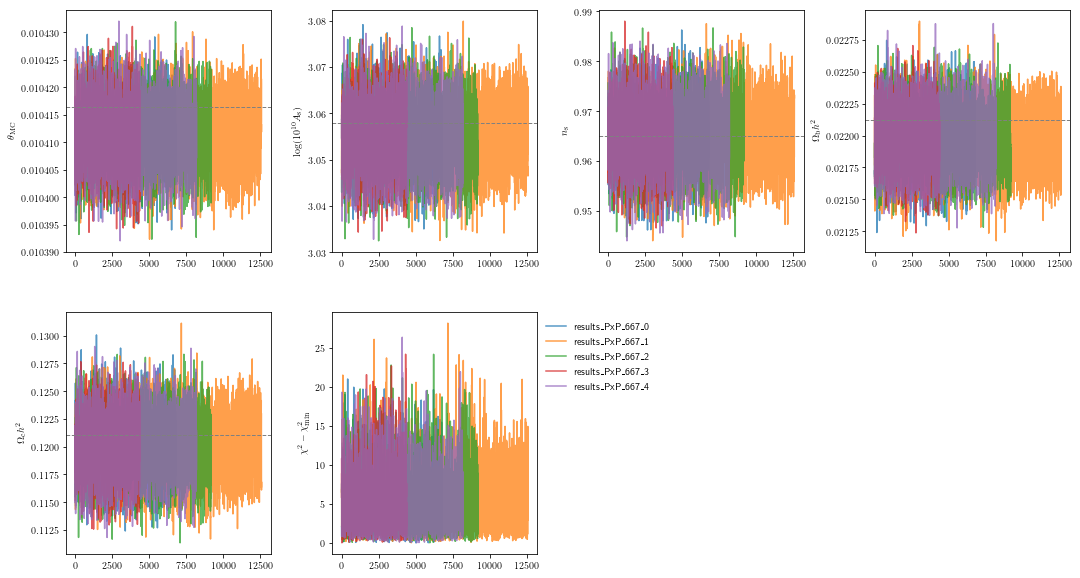

In [1]:
plot_chains(result_path + "/*_PxP_*/mcmc*.txt", burnin=0)

#### Triangle plot



In [1]:
def get_samples(path):
    chains = get_chains(path)
    key = next(iter(chains))
    samples = chains[key].iloc[:, 1:].values
    weights = chains[key].iloc[:, 0].values
    return samples, weights

# Out[242]:

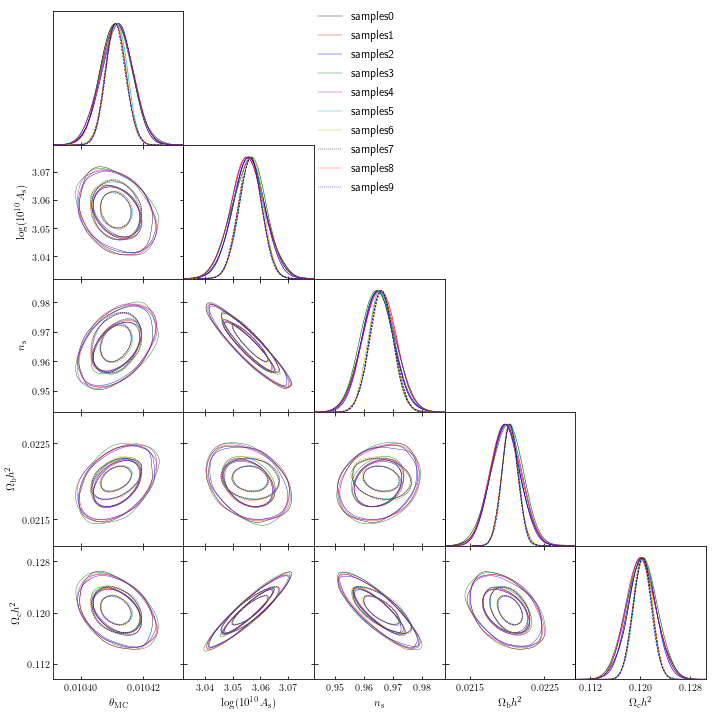

In [1]:
samples = []
surveys = ["PxP"]#, "SOxSO", "SOxP", "SOxSO-PxP", "SOxP-PxP", "SOxP-SOxSO"]
for survey in surveys:
    for i in range(5):
        s, w = get_samples(result_path + "/*_{}_*{}/mcmc*.txt".format(survey, i))
        samples += [MCSamples(samples=s, names=labels, weights=w, ignore_rows=0.3)]

g = plots.getSubplotPlotter()
g.triangle_plot(samples, params=labels[:-2])

#### Plot variances from MCMC and Hessian



##### Compute standard deviation from MCMC



In [1]:
def get_mcmc_variances(path, burnin=0.3, keep_As=False):
    table = []
    lines = []
    all_files = glob.glob(path)
    if len(all_files) == 0:
      return np.array(table)
    all_files.sort()
    for f in all_files:
        samples, weights = get_samples(f)
        mcsamples = MCSamples(samples=samples, weights=weights, ignore_rows=burnin)
        sigmas = np.sqrt(mcsamples.getVars()).tolist()
        if keep_As:
            del sigmas[-2]
            table += [sigmas]
        else:
            table += [sigmas[:-2]]
        lines += [[f.split("/")[-2]]]
    table = np.append(lines, table, axis=1)
    return table

##### Compare MCMC to minimization and Fisher



| PxP|$\theta_\mathrm{MC}$|$A_\mathrm{s}$|$n_\mathrm{s}$|$\Omega_\mathrm{b}h^2$|$\Omega_\mathrm{c}h^2$|
|---|---|---|---|---|---|
| $\sigma$ (Minimization)|4.99937e-06|1.24047e-11|0.00544548|0.000206822|0.0022281|
| $\sigma$ (Minimization 2;3000)|4.88563e-06|1.22407e-11|0.00529792|0.000204028|0.0022389|
| $\sigma$ (Fisher)|5.12655e-06|1.28546e-11|0.00558972|0.000203823|0.00233404|
| $\sigma$ (MCMC)|3.60082e-06|0.89984e-11|0.00394778|0.000143322|0.00162962|
| $\Delta\sigma$ (min-Fisher) [%]|-2.48081|-3.5002|-2.58047|1.47141|-4.5391|
|---|---|---|---|---|---|
| SOxSO|$\theta_\mathrm{MC}$|$A_\mathrm{s}$|$n_\mathrm{s}$|$\Omega_\mathrm{b}h^2$|$\Omega_\mathrm{c}h^2$|
|---|---|---|---|---|---|
| $\sigma$ (Minimization)|3.30158e-06|8.82142e-12|0.00403527|0.000113061|0.00147556|
| $\sigma$ (Fisher)|3.31809e-06|9.02724e-12|0.00410550|0.000112680|0.00148535|
|---|---|---|---|---|---|
| SOxP|$\theta_\mathrm{MC}$|$A_\mathrm{s}$|$n_\mathrm{s}$|$\Omega_\mathrm{b}h^2$|$\Omega_\mathrm{c}h^2$|
|---|---|---|---|---|---|
| $\sigma$ (Minimization)|4.13856e-06|1.10042e-11|0.0048009|0.000153239|0.00196259|
| $\sigma$ (Fisher)|4.20292e-06|1.13107e-11|0.0049306|0.000153280|0.00199297|



# Out[1084]:

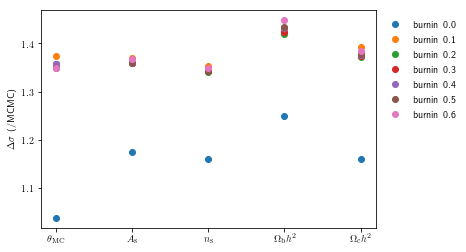

In [1]:
for i in np.arange(0, 0.7, 0.1):
    mcmc = get_mcmc_variances(result_path + "/results*_PxP_*[0-4]/mcmc*.txt", keep_As=True, burnin=i)
    mcmc = np.mean(np.array(mcmc[:, 1:], dtype=np.float), axis=0)
    mcmc[1] = mcmc[-1] # Use As for comparison
    plt.plot(ref_std[:-1]/mcmc[:-1], "o", label="burnin {:.1f}".format(i))

plt.ylabel(r"$\sigma$(Fisher)/$\sigma$(MCMC)$")
xlabels = [r"$\theta_\mathrm{MC}$",
          r"$A_\mathrm{s}$",
          r"$n_\mathrm{s}$",
          r"$\Omega_\mathrm{b}h^2$",
          r"$\Omega_\mathrm{c}h^2$"]
plt.xticks(np.arange(len(xlabels)), xlabels)
plt.legend(loc="upper left", bbox_to_anchor=(1,1))

##### From Hessian



In [1]:
import pickle
def get_hessians(f):
    d = pickle.load(open(f, "rb"))
    # except:
    #     print("Fail to open {}".format(f))
    #     pass
    hess = d["results"]["OptimizeResult"]["hess_inv"]
    return np.sqrt(np.diagonal(hess))

def get_hessians_table(path):
    table = []
    lines = []
    files = glob.glob(path)
    files.sort()
    for f in files:
        table += [get_hessians(f).tolist()]
        lines += [[f.split("/")[-2]]]

    table = np.append(lines, table, axis=1)
    return table

In [1]:
table = get_hessians_table(result_path + "/output*/min*.pkl")
display(HTML(tabulate.tabulate(table, headers=labels[:-2], tablefmt="html")))

##### Summary



# Out[354]:
q

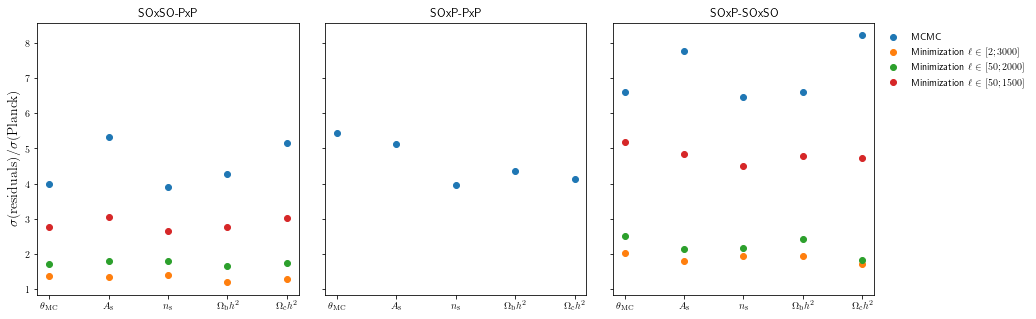

In [1]:
mcmc = {}
surveys = ["PxP", "SOxSO-PxP", "SOxP-PxP", "SOxP-SOxSO"]
for survey in surveys:
    mcmc_var = get_mcmc_variances(result_path + "/results*_{}_*/mcmc*.txt".format(survey), burnin=0.3, keep_As=True)
    if mcmc_var.size != 0:
        mcmc_var = np.mean(np.array(mcmc_var[:, 1:], dtype=np.float), axis=0)
        # Use As
        mcmc_var[1] = mcmc_var[-1]; mcmc_var = mcmc_var[:-1]
        mcmc[survey] = mcmc_var
fig, ax = plt.subplots(1, len(surveys)-1, sharex="col", sharey="row", figsize=(15, 5))
xlabels = [r"$\theta_\mathrm{MC}$",
           r"$A_\mathrm{s}$",
           r"$n_\mathrm{s}$",
           r"$\Omega_\mathrm{b}h^2$",
           r"$\Omega_\mathrm{c}h^2$"]
x = np.arange(len(xlabels))
for i, survey in enumerate(surveys[1:]):
    ax[i].plot(x, mcmc["PxP"]/mcmc[survey], "o")
    ax[i].set_title(survey)
    ax[i].set_xticks(x)
    ax[i].set_xticklabels(xlabels)

ax[0].set_ylabel(r"$\sigma{\rm(residuals)}/\sigma{\rm(Planck)}$", fontsize=14)
plt.subplots_adjust(wspace=0.1)

mini = {}
mini["SOxSO-PxP"] = [min_l_2_3000[6][1:-1], min_l_50_2000[6][1:-1], min_l_50_1500[6][1:-1]]
mini["SOxP-SOxSO"] = [min_l_2_3000[7][1:-1], min_l_50_2000[7][1:-1], min_l_50_1500[7][1:-1]]
for i in mini["SOxSO-PxP"]:
    ax[0].plot(x, mcmc["PxP"]/np.array(i, dtype=np.float), "o")
for i in mini["SOxP-SOxSO"]:
    ax[2].plot(x, mcmc["PxP"]/np.array(i, dtype=np.float), "o")

ax[2].legend(["MCMC",
              r"Minimization $\ell\in[2;3000]$",
              r"Minimization $\ell\in[50;2000]$",
              r"Minimization $\ell\in[50;1500]$"],
             loc="upper left", bbox_to_anchor=(1,1))

### \Lambda CDM + ALens



In [1]:
labels = [r"$\theta_\mathrm{MC}$",
          r"$\log(10^{10}A_\mathrm{s})$",
          r"$n_\mathrm{s}$",
          r"$\Omega_\mathrm{b}h^2$",
          r"$\Omega_\mathrm{c}h^2$",
          r"$\mathrm{A}_\mathrm{L}$",
          r"$\chi^2-\chi^2_\mathrm{min}$",
          r"$A_\mathrm{s}$"]

result_path = r"/home/garrido/Workdir/CMB/analysis/beyondCV/output/ALens"

#### Check minimization



Get Hessians from minimizations



In [1]:
def check_minimization(path):
    all_files = glob.glob(path)
    all_files.sort()
    table = []
    for f in all_files:
        import pickle
        opt_result =  pickle.load(open(f, "rb"))["results"]["OptimizeResult"]
        msg = opt_result.get("message")
        ntry = opt_result.get("ntry")
        proposal = np.sqrt(np.diag(opt_result.get("hess_inv")))
        table += [[f.split("/")[-2], msg, ntry, *proposal]]
    return table

headers = ["" for i in range(len(table))]
headers[0:3] = ["Directory", "Status", "ntry"]
table = check_minimization(result_path + "/results_*/min*.pkl")
print(tabulate.tabulate(table, headers=headers, tablefmt="orgtbl"))

| Directory                | Status                                                        | ntry |             |             |             |             |             |            |
|--------------------------+---------------------------------------------------------------+------+-------------+-------------+-------------+-------------+-------------+------------|
| results_PxP_666_0        | Optimization terminated successfully.                         |    1 | 2.45279e-06 |  0.00127271 |  0.00173696 | 1.92859e-05 | 0.000102676 |  0.0371089 |
| results_PxP_666_1        | Optimization terminated successfully.                         |    3 | 2.51867e-06 |  0.00127433 |  0.00174105 | 1.98167e-05 | 0.000104576 |  0.0372196 |
| results_PxP_666_2        | Optimization failed. Estimated distance to minimum too large. |   10 | 7.88674e-06 |   0.0054606 |  0.00336989 | 0.000469289 |  0.00161214 |  0.0321427 |
| results_PxP_666_3        | Optimization terminated successfully.                   

#### Check chains



##### PxP



# Out[444]:

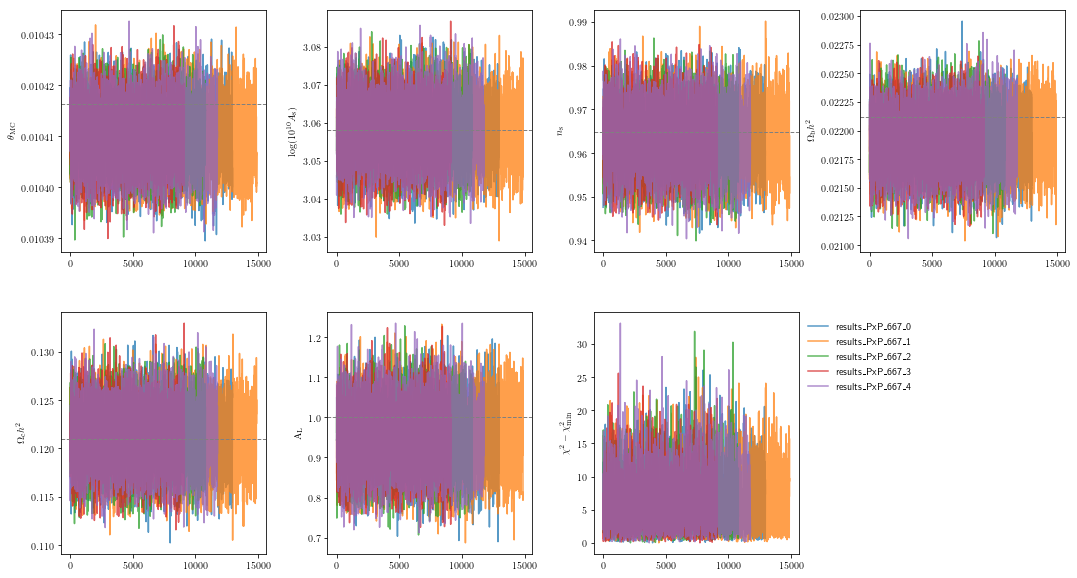

In [1]:
plot_chains(result_path + "/*_PxP_*/mcmc*.txt", burnin=0, labels=labels)

##### SOxSO



# Out[229]:

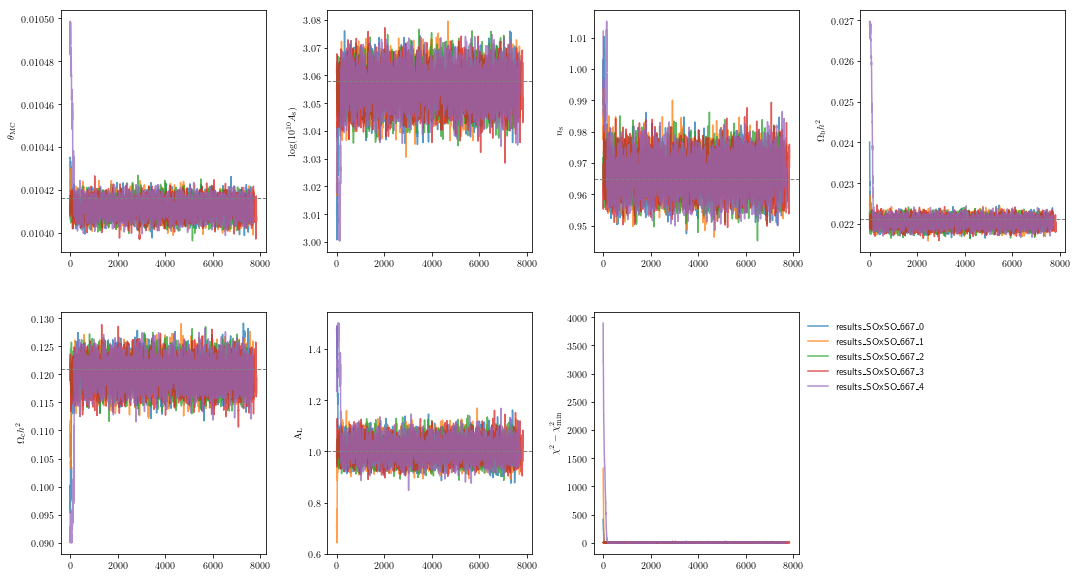

In [1]:
plot_chains(result_path + "/*_SOxSO_*/mcmc*.txt", burnin=0, labels=labels)

##### SOxP



# Out[246]:

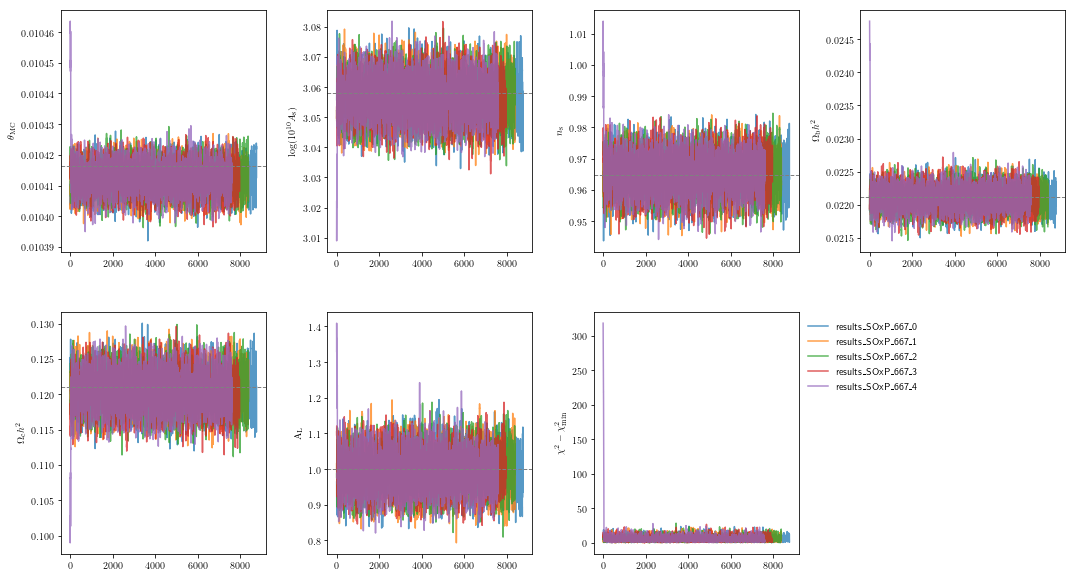

In [1]:
plot_chains(result_path + "/*_SOxP_*/mcmc*.txt", burnin=0, labels=labels)

##### SOxSO - PxP



# Out[449]:

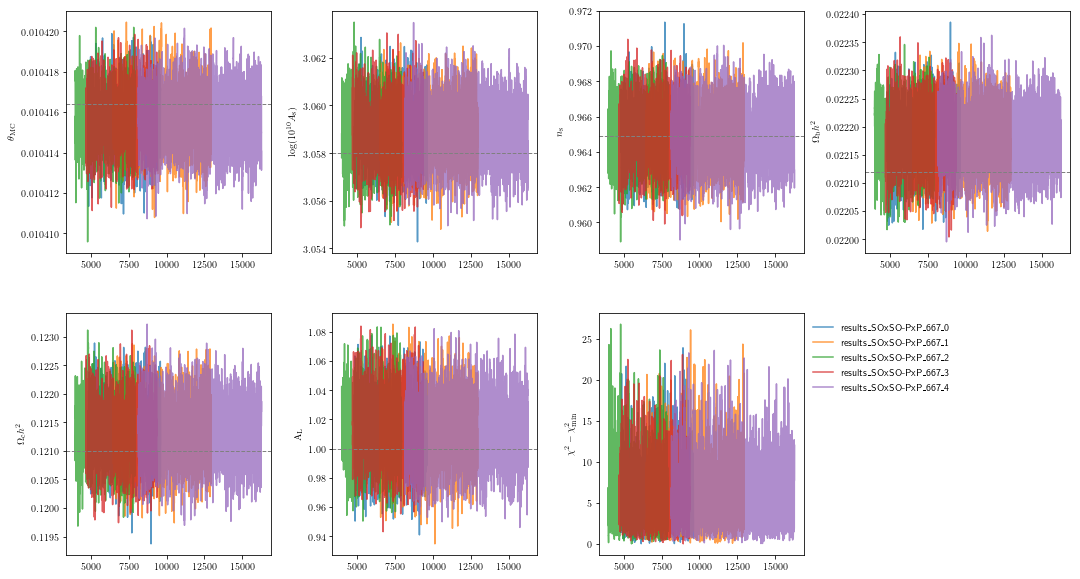

In [1]:
plot_chains(result_path + "/*_SOxSO-PxP_*/mcmc*.txt", burnin=0.5, labels=labels)

##### SOxP - PxP



# Out[448]:

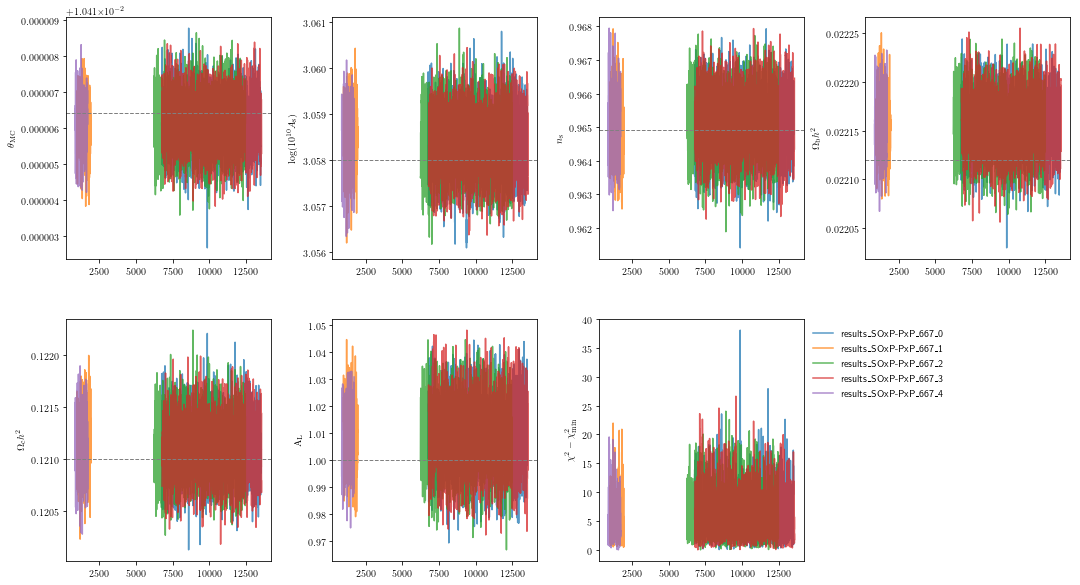

In [1]:
plot_chains(result_path + "/*_SOxP-PxP*/mcmc*.txt", burnin=0.5, labels=labels)

##### SOxP - SOxSO



# Out[447]:

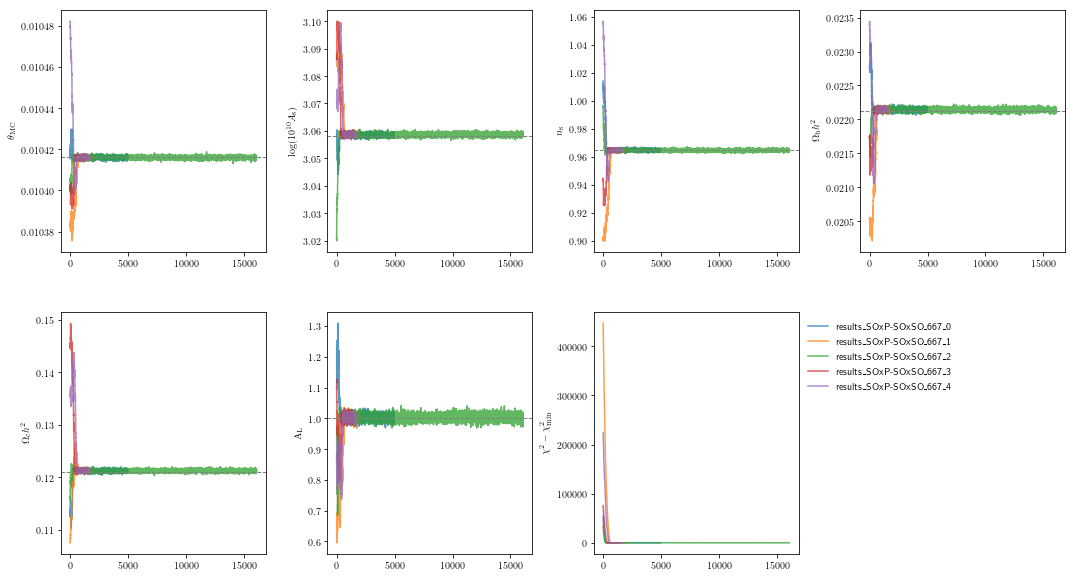

In [1]:
plot_chains(result_path + "/*_SOxP-SOxSO*/mcmc*.txt", burnin=0, labels=labels)

#### Triangle plot



In [1]:
def plot_samples(path, burnin=0.3, colors=None, scale=None, labels=labels, legend=None):
    samples = []
    the_colors = []
    all_files = []
    if isinstance(path, list):
        for p in path:
            all_files.extend(glob.glob(p))
    else:
        all_files = glob.glob(path)
        all_files.sort()
    for f in all_files:
        s, w = get_samples(f)
        s = s[:, :-2]
        if scale:
            renorm = np.array(scale)/(w.dot(s)/np.sum(w))
            s *= renorm
        survey = f.split("/")[-2]
        i = survey.split("_")[-1]
        survey = survey.split("_")[1]
        samples += [MCSamples(samples=s, names=labels[:-2], label="{} - MCMC {}".format(survey, i), weights=w, ignore_rows=burnin)]
        the_colors += ["-C{}".format(i)]

    g = plots.getSubplotPlotter()
    g.settings.lineM = colors if colors else the_colors
    if legend:
        g.triangle_plot(samples, params=labels[:-2], legend_labels=[])
        g.add_legend(legend, colored_text=True, figure=True, align_right=True)
    else:
        g.triangle_plot(samples, params=labels[:-2])

# Out[566]:

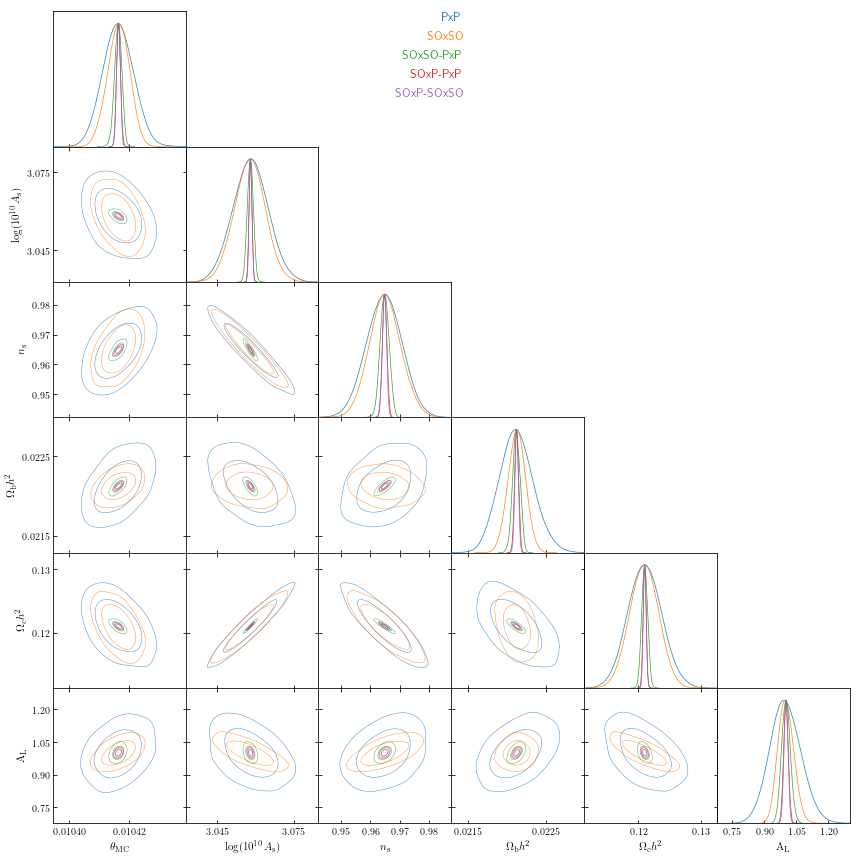

In [1]:
ref = [1.04164/100, 3.058, 0.9649, 0.02212, 0.1210, 1]
mcmc_survey= ["PxP", "SOxSO", "SOxSO-PxP", "SOxP-PxP", "SOxP-SOxSO"]
mcmc_nbr = ["2"]
paths = []
for f in mcmc_survey:
  for g in mcmc_nbr:
    paths += [result_path + "/*_{}_*{}/mcmc*.txt".format(f,g)]
colors = []
for i,_ in enumerate(mcmc_survey):
    colors += len(mcmc_nbr)*["-C{}".format(i)]
plot_samples(path=paths, burnin=0.5, scale=ref, colors=colors, legend=mcmc_survey)

#### Plot variances from MCMC



# Out[577]:

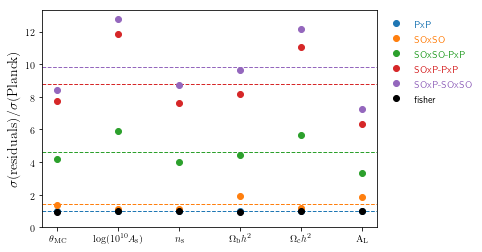

In [1]:
use_As = False
mcmc_nbr = ["2"]
mcmc = {}
surveys = ["PxP", "SOxSO", "SOxSO-PxP", "SOxP-PxP", "SOxP-SOxSO"]
for survey in surveys:
    mcmc_var = get_mcmc_variances(result_path + "/results*_{}_*{}/mcmc*.txt".format(survey, ",".join(mcmc_nbr)), burnin=0.3, keep_As=use_As)
    if mcmc_var.size != 0:
        mcmc_var = np.mean(np.array(mcmc_var[:, 1:], dtype=np.float), axis=0)
        if use_As:
            # Use As
            mcmc_var[1] = mcmc_var[-1]; mcmc_var = mcmc_var[:-1]
        mcmc[survey] = mcmc_var
xlabels = [r"$\theta_\mathrm{MC}$",
           r"$\log(10^{10}A_\mathrm{s})$",
           r"$n_\mathrm{s}$",
           r"$\Omega_\mathrm{b}h^2$",
           r"$\Omega_\mathrm{c}h^2$",
          r"$\mathrm{A}_\mathrm{L}$"]
if use_As:
    xlabels[1] = r"$A_\mathrm{s}$"
x = np.arange(len(xlabels))
for i, survey in enumerate(surveys):
    y = mcmc["PxP"]/mcmc[survey]
    plt.plot(x, y, "o", label=survey, color="C{}".format(i))
    plt.axhline(np.mean(y), color="C{}".format(i), ls="--", lw=1)

fisher = np.array([5.488784226430075e-06, 0.006886322958075309, 0.006082145093362834, 0.00022563053346601842, 0.0027330648180420945, 0.07145648912030945])
plt.plot(x, mcmc["PxP"]/fisher, "ok", label="fisher")
plt.xticks(x, xlabels)
plt.ylabel(r"$\sigma{\rm(residuals)}/\sigma{\rm(Planck)}$", fontsize=14)
plt.ylim(0,)
leg = plt.legend(loc="upper left", bbox_to_anchor=(1,1))
for i, text in enumerate(leg.get_texts()[:-1]):
    text.set_color("C{}".format(i))

### \Lambda CDM + H0



In [1]:
labels = [r"$H_0$",
          r"$\log(10^{10}A_\mathrm{s})$",
          r"$n_\mathrm{s}$",
          r"$\Omega_\mathrm{b}h^2$",
          r"$\Omega_\mathrm{c}h^2$",
          r"$\mathrm{A}_\mathrm{L}$",
          r"$\chi^2-\chi^2_\mathrm{min}$",
          r"$A_\mathrm{s}$"]

result_path = r"/home/garrido/Workdir/CMB/analysis/beyondCV/output/H0"

#### Check chains



##### PxP



# Out[467]:

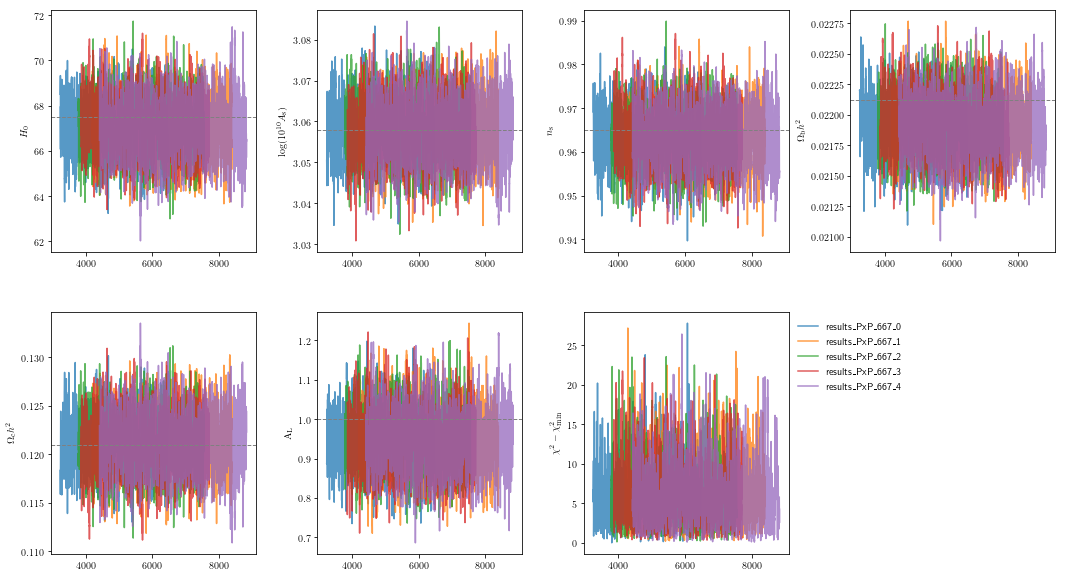

In [1]:
plot_chains(result_path + "/*_PxP_*/mcmc*.txt", burnin=0.5, labels=labels)

##### SOxSO



# Out[258]:

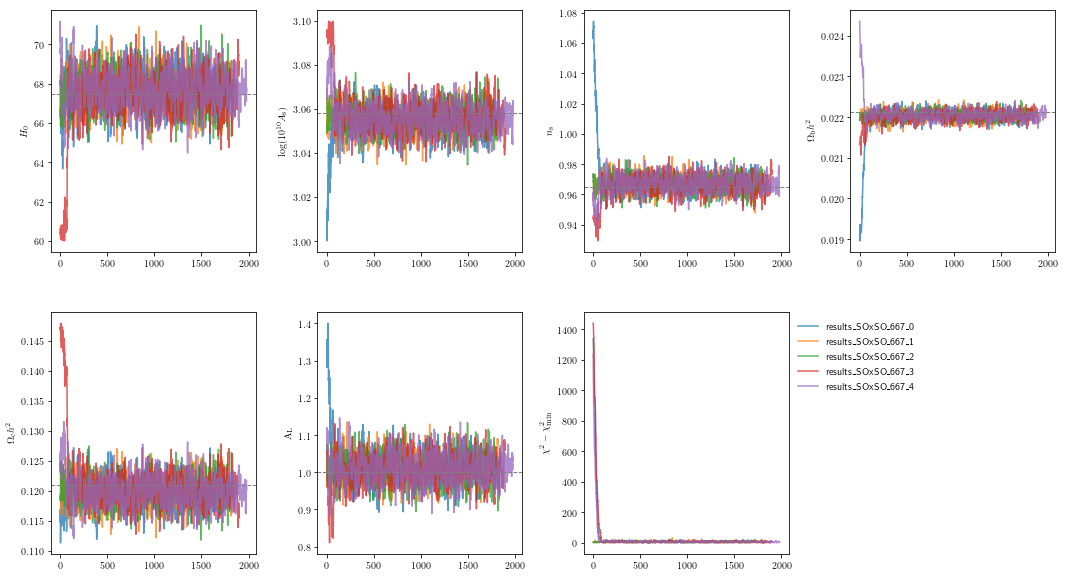

In [1]:
plot_chains(result_path + "/*_SOxSO_*/mcmc*.txt", burnin=0, labels=labels)

##### SOxP



# Out[259]:

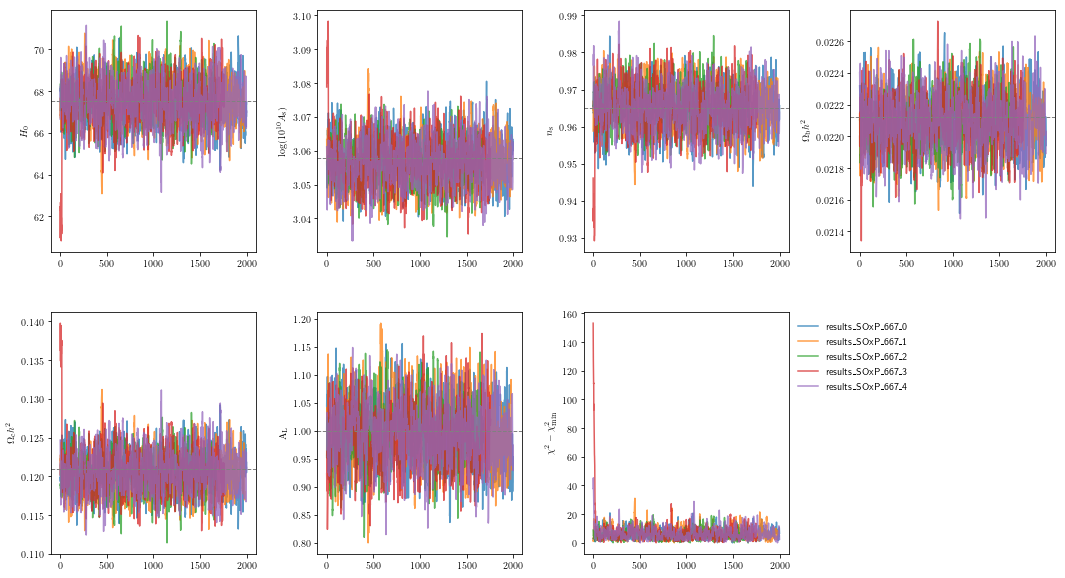

In [1]:
plot_chains(result_path + "/*_SOxP_*/mcmc*.txt", burnin=0, labels=labels)

##### SOxSO - PxP



# Out[468]:

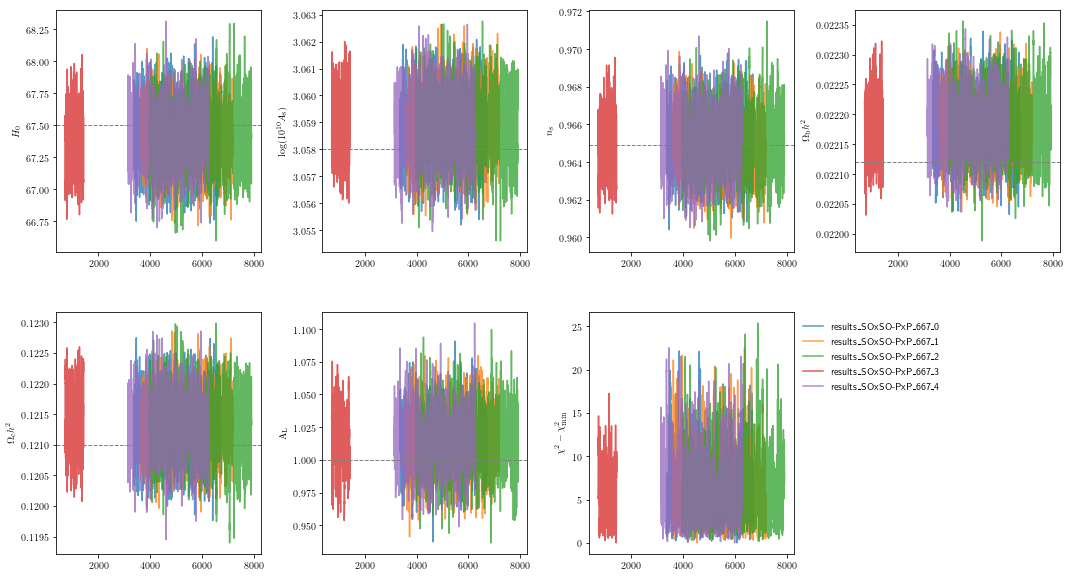

In [1]:
plot_chains(result_path + "/*_SOxSO-PxP_*/mcmc*.txt", burnin=0.5, labels=labels)

##### SOxP - PxP



# Out[469]:

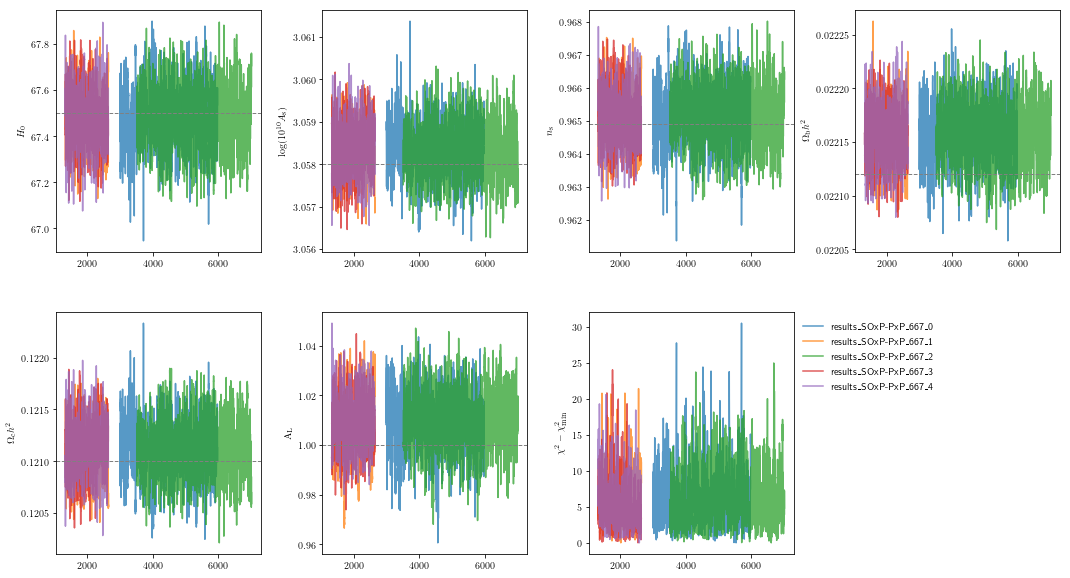

In [1]:
plot_chains(result_path + "/*_SOxP-PxP*/mcmc*.txt", burnin=0.5, labels=labels)

##### SOxP - SOxSO



# Out[470]:

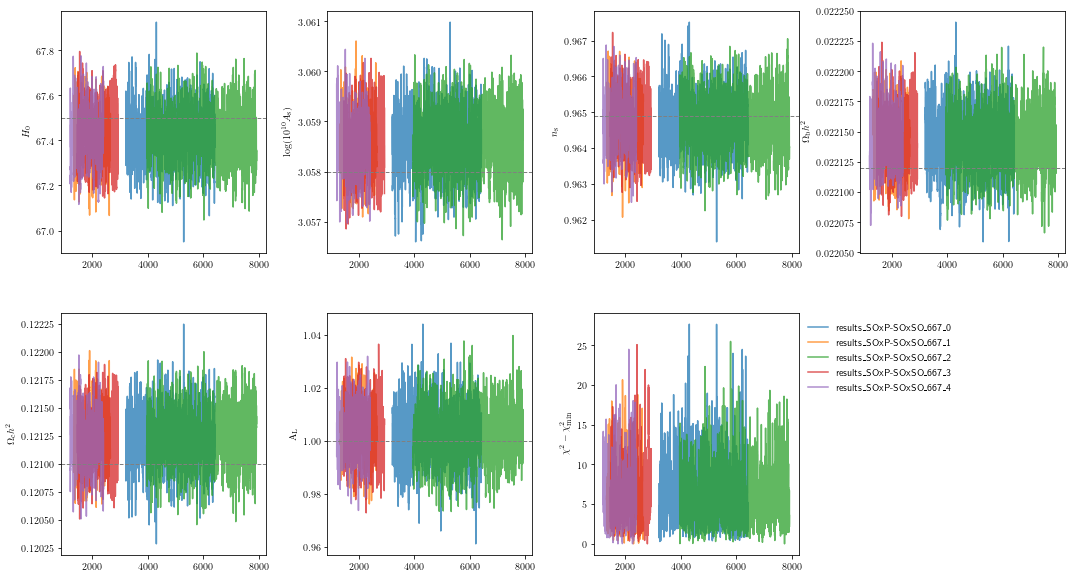

In [1]:
plot_chains(result_path + "/*_SOxP-SOxSO*/mcmc*.txt", burnin=0.5, labels=labels)

#### Triangle plot



# Out[569]:

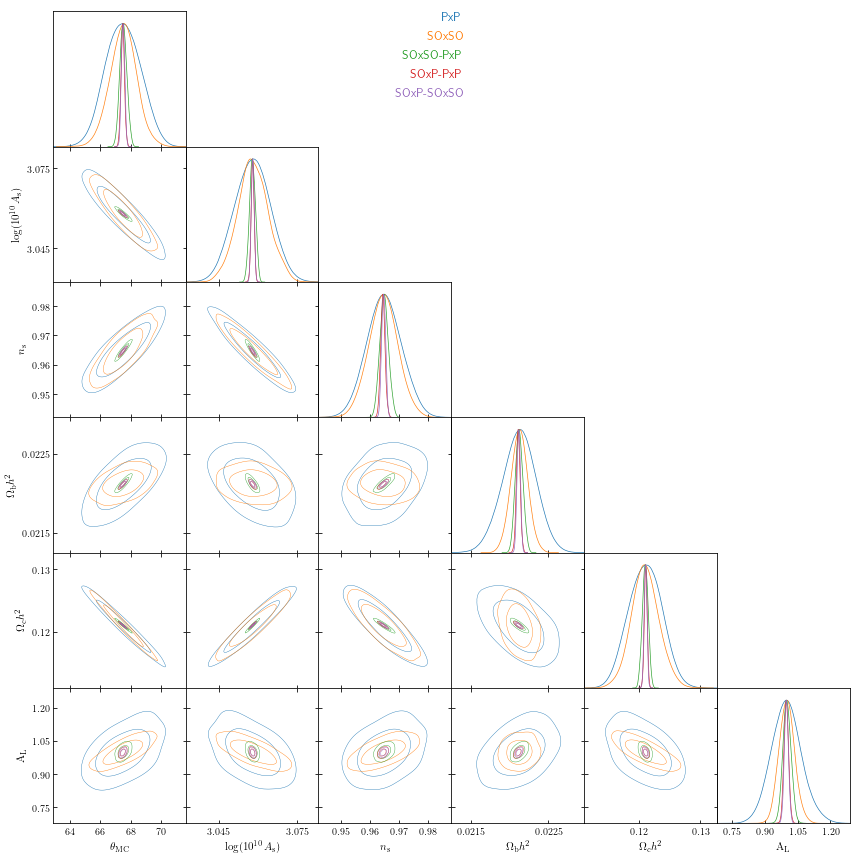

In [1]:
ref = [67.5, 3.058, 0.9649, 0.02212, 0.1210, 1]
mcmc_survey= ["PxP", "SOxSO", "SOxSO-PxP", "SOxP-PxP", "SOxP-SOxSO"]
mcmc_nbr = ["0"]
paths = []
for f in mcmc_survey:
  for g in mcmc_nbr:
    paths += [result_path + "/*_{}_*{}/mcmc*.txt".format(f,g)]
colors = []
for i,_ in enumerate(mcmc_survey):
    colors += len(mcmc_nbr)*["-C{}".format(i)]
plot_samples(path=paths, burnin=0.5, scale=ref, colors=colors, legend=mcmc_survey)

#### Plot variances from MCMC



# Out[578]:

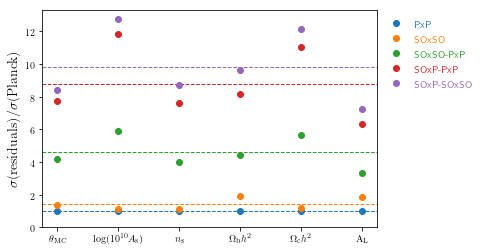

In [1]:
use_As = False
mcmc_nbr = ["2"]
mcmc = {}
surveys = ["PxP", "SOxSO", "SOxSO-PxP", "SOxP-PxP", "SOxP-SOxSO"]
for survey in surveys:
    mcmc_var = get_mcmc_variances(result_path + "/results*_{}_*{}/mcmc*.txt".format(survey, ",".join(mcmc_nbr)), burnin=0.3, keep_As=use_As)
    if mcmc_var.size != 0:
        mcmc_var = np.mean(np.array(mcmc_var[:, 1:], dtype=np.float), axis=0)
        if use_As:
            # Use As
            mcmc_var[1] = mcmc_var[-1]; mcmc_var = mcmc_var[:-1]
        mcmc[survey] = mcmc_var
xlabels = labels[:-2]
if use_As:
    xlabels[1] = r"$A_\mathrm{s}$"

x = np.arange(len(xlabels))
for i, survey in enumerate(surveys):
    y = mcmc["PxP"]/mcmc[survey]
    plt.plot(x, y, "o", label=survey, color="C{}".format(i))
    plt.axhline(np.mean(y), color="C{}".format(i), ls="--", lw=1)

fisher = np.array([1.1685398799157372, 0.006836962297205166, 0.006080663682347812, 0.00022536977360943547, 0.0027340459518635477, 0.07147321760124377])
# plt.plot(x, mcmc["PxP"]/fisher, "ok", label="fisher")

plt.xticks(x, xlabels)
plt.ylabel(r"$\sigma{\rm(residuals)}/\sigma{\rm(Planck)}$", fontsize=14)
plt.ylim(0,)
leg = plt.legend(loc="upper left", bbox_to_anchor=(1,1))
for i, text in enumerate(leg.get_texts()):
  text.set_color("C{}".format(i))